# Análisis de Comportamiento de Hashtag #ProhibidoOlvidarSV

**Autora del análisis**: Jocelyn Castellanos

**Creador del Dataset**: [Mario Gómez](https://twitter.com/mxgxw_alpha)

## Descripción General:

Este análisis surge de la iniciativa creada por Mario en conmemoración del aniversario de los Acuerdos de Paz, suceso ocurrido en El Salvador el 16 de enero de 1992. Esta iniciativa empezó el 11 de enero del año 2021, llegando a extenderse hasta el 17 de enero del 2021.

## 1. Importación de librerías

Se importan todas aquellas librerías a utilizar y se establecen configuraciones previas que se utilizarán a lo largo de todo el Notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt 
from nltk.corpus import stopwords

sns.set(color_codes=True)
sns.set_style('darkgrid')
sws = stopwords.words('spanish')
swe = stopwords.words('english')

%matplotlib inline

## 2. Importación de los datos

A través de la librería de Pandas, transformamos el CSV donde se contiene la información a un formato que es fácilmente manipulable: Un DataFrame.

Para conocer más o menos como están estructurados los datos, se revisan los primeros 5 registros de este Conjunto de datos.

In [2]:
df = pd.read_csv('../datasets/prohibidoOlvidarSV-Standard-SinID.csv')
df.head(5)

,date,is_retweet,full_text
0,Sun Jan 17 17:19:22 +0000 2021,1,RT @car_umba: Deslegitimizar los Acuerdos de P...
1,Sun Jan 17 17:19:22 +0000 2021,1,RT @ccdinarte2010: Y el dichoso decreto no sól...
2,Sun Jan 17 17:19:18 +0000 2021,0,#ProhibidoOlvidarSV\n#BukeleElFragmentado http...
3,Sun Jan 17 17:19:11 +0000 2021,0,Arcatao es lucha 🔥 #ProhibidoOlvidarSV https:/...
4,Sun Jan 17 17:19:08 +0000 2021,1,RT @nayibbukele: Y así fue...\n\n#ProhibidoOlv...


## 3. Vista previa de los datos

In [3]:
print(f'El Dataset contiene {df.shape[0]} registros')
print(f'El Dataset contiene {df.shape[1]} columnas, que son {", ".join(df.columns.values)}')
print(f'\nRegistros nulos por columna: \n{df.isnull().sum()}')
print(f'\nTipos de datos por columna: \n{df.dtypes}')

El Dataset contiene 81244 registros
El Dataset contiene 3 columnas, que son date, is_retweet, full_text

Registros nulos por columna: 
date          0
is_retweet    0
full_text     0
dtype: int64

Tipos de datos por columna: 
date          object
is_retweet     int64
full_text     object
dtype: object


## 4. Tratamiento de los datos

Para poder aprovechar la información lo más posible, es necesario hacer un tratamiento previo de esta. 

- Se estandariza la fecha con el método to_datetime, otorgado por Pandas
- Ya que el tipo de dato DateTime permite interactuar con cada elemento de la fecha de un registro, se extrae la hora y el nombre del día de la fecha del registro.
- Se realiza un mapeo en donde se pasan los nombres de los días de inglés a español (para más comodidad de lectura)
- Se realiza un mapeo para cambiar los valores de la columna "is_retweet"

In [4]:
# Se convierte toda la columna de "date" al tipo de dato Datetime.
df['date'] = pd.to_datetime(df['date'])

# Se extraen las horas de las fechas de todos los registros y se guardan en una nueva columna.
df['hour'] = df['date'].dt.hour

# De igual forma, se extrae no el número, sino el nombre del día de la fecha de todos los registros y es nuevamente guardada en una nueva columna.
df['day'] = df['date'].dt.day_name()

# Mapeo que intercambia valores a través de un diccionario de tipo clave-valor.
df['day'] = df['day'].map({'Monday':'Lunes','Tuesday':'Martes','Wednesday':'Miércoles','Thursday':'Jueves','Friday':'Viernes','Saturday':'Sábado','Sunday':'Domingo'})

# Otro mapeo que intercambia valores a través de un diccionario.
df['is_retweet'] = df['is_retweet'].map({1:True,0:False})

Al revisar la columna de texto se puede observar que tiene elementos como la palabra "RT", o que tiene incluso el nombre del usuario que publicó el Tweet. 

Debido a esto, se realiza un tratamiento a la tabla en donde se realiza lo siguiente:

- Se elimina la palabra "RT" de aquellos registros que la tengan
- Para saber si un texto tiene el usuario que lo publicó se analiza si el primer digito empieza con una @
- Para saber si un texto no tiene el usuario que lo publicó se analiza si el primer digito no empieza con una @
- Para normalizar los datos, se pasan todos los textos a minúscula (esto facilita la evaluación de palabras)

In [5]:
# Con un apply se revisa registro a registro y se evalua si cumplen una condición, regresando un resultado si se cumple u otro si no se cumple.

# Se reemplazan los caractéres "RT" por... nada, si el texto contiene estos caracteres
df['text'] = df['full_text'].apply(lambda x: x.replace("RT ","") if x.__contains__("RT") else x)


"""
Se evalúa si el primer caracter del texto es una @. De ser así, se divide el texto en 2 con el método split.
Como este método regresa una lista del texto dividido en antes y después del caracter, se divide el texto a partir del primer espacio que se encuentre.
Por lo general, la estructura de los textos con usuarios es: "@Usuario blablabla", por lo que el split regresa un valor como: ['@Usuario', 'blablabla']
Ya que queremos quedarnos con el usuario, se indica que se desea el valor ubicado en la primera posición: split(" ")[0]
Si el texto no tiene un usuario, simplemente se retorna un None.
"""
df['user'] = df['text'].apply(lambda x: x.split(" ")[0].replace(":","") if x[0] == '@' else None)


"""
Funcionamiento similar para la extracción de usuario, pero de manera inversa.
En el split, en lugar de quedarnos con la primera posición nos quedaremos con la segunda, ya que la primera es en donde se ubica el usuario pero la segunda
en donde se ubica el texto del tweet como tal.
"""
df['text'] = df['text'].apply(lambda x: x.split(" ",1)[1].strip() if x[0] == '@' else x.strip())


# Se pasan todos los textos a minúscula.
df['text']= df['text'].str.lower()

In [6]:
# Vista previa del dataset con las nuevas columnas
df

,date,is_retweet,full_text,hour,day,text,user
0,2021-01-17 17:19:22+00:00,True,RT @car_umba: Deslegitimizar los Acuerdos de P...,17,Domingo,deslegitimizar los acuerdos de paz es atacar l...,@car_umba
1,2021-01-17 17:19:22+00:00,True,RT @ccdinarte2010: Y el dichoso decreto no sól...,17,Domingo,y el dichoso decreto no sólo fue redactado con...,@ccdinarte2010
2,2021-01-17 17:19:18+00:00,False,#ProhibidoOlvidarSV\n#BukeleElFragmentado http...,17,Domingo,#prohibidoolvidarsv\n#bukeleelfragmentado http...,None
3,2021-01-17 17:19:11+00:00,False,Arcatao es lucha 🔥 #ProhibidoOlvidarSV https:/...,17,Domingo,arcatao es lucha 🔥 #prohibidoolvidarsv https:/...,None
4,2021-01-17 17:19:08+00:00,True,RT @nayibbukele: Y así fue...\n\n#ProhibidoOlv...,17,Domingo,y así fue...\n\n#prohibidoolvidarsv https://t....,@nayibbukele
...,...,...,...,...,...,...,...
81239,2021-01-11 14:49:30+00:00,True,RT @mxgxw_alpha: Yo voy a usar el hashtag #Pro...,14,Lunes,yo voy a usar el hashtag #prohibidoolvidarsv s...,@mxgxw_alpha
81240,2021-01-11 14:49:13+00:00,False,Mi madre estudió en la UES. Cuenta como en la ...,14,Lunes,mi madre estudió en la ues. cuenta como en la ...,None
81241,2021-01-11 14:47:47+00:00,True,RT @mxgxw_alpha: Yo voy a usar el hashtag #Pro...,14,Lunes,yo voy a usar el hashtag #prohibidoolvidarsv s...,@mxgxw_alpha
81242,2021-01-11 14:43:06+00:00,False,@mxgxw_alpha Sus aportes de la histydw la guer...,14,Lunes,sus aportes de la histydw la guerra serán bie...,@mxgxw_alpha


## 5. Categorización de los textos (en construcción 🛠)*

En resumen, es determinar si en un texto se habla de un determinado tema u otro dependiendo de si tiene ciertos caracteres que puedan indicar un término.

*Se toman en consideración sinónimos de estos términos.*

In [49]:
df_tw = df[df['is_retweet']==False]
df_tw = df_tw.assign(Category = 'Ninguna')
texto = df_tw['text'].copy().astype(str)
cat = []

for i in range(len(df_tw)):
    if (texto.iloc[i].__contains__('ases')) | (texto.iloc[i].__contains__('mata')) | (texto.iloc[i].__contains__('kill')) | (texto.iloc[i].__contains__('ejecu')) | (texto.iloc[i].__contains__('decap')) | (texto.iloc[i].__contains__('cuerpo')):
        cat.append('Asesinato/Muerte')
    if (texto.iloc[i].__contains__('secuest')) | (texto.iloc[i].__contains__('rapt')) | (texto.iloc[i].__contains__('reten')) | (texto.iloc[i].__contains__('retuv')) | (texto.iloc[i].__contains__('encerr')):
        cat.append('Secuestro')     
    if (texto.iloc[i].__contains__('desap')) | (texto.iloc[i].__contains__('dissape')):
        cat.append('Desaparición')
    if (texto.iloc[i].__contains__('tiro')) | (texto.iloc[i].__contains__('bala')) | (texto.iloc[i].__contains__('cuet')):
        cat.append('Tiroteo')
    else:
        cat.append('Ninguna')
        
    df_tw['Category'].iloc[i] = ', '.join(cat)
    cat = []

C:\Users\Jocelyn\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
df_tw.groupby('Category')['text'].count()

Category
Asesinato/Muerte, Desaparición, Ninguna                  89
Asesinato/Muerte, Ninguna                               939
Asesinato/Muerte, Secuestro, Desaparición, Ninguna        8
Asesinato/Muerte, Secuestro, Desaparición, Tiroteo        1
Asesinato/Muerte, Secuestro, Ninguna                     54
Asesinato/Muerte, Secuestro, Tiroteo                      2
Asesinato/Muerte, Tiroteo                                63
Desaparición, Ninguna                                   303
Desaparición, Tiroteo                                     7
Ninguna                                               10533
Secuestro, Desaparición, Ninguna                         14
Secuestro, Ninguna                                      133
Secuestro, Tiroteo                                       18
Tiroteo                                                 307
Name: text, dtype: int64

In [74]:
df_tw['Category'].unique()

array(['Ninguna', 'Asesinato, Secuestro, Ninguna', 'Asesinato, Tiroteo',
       'Tiroteo', 'Asesinato, Ninguna', 'Secuestro, Ninguna',
       'Desaparecer, Ninguna', 'Asesinato, Desaparecer, Ninguna',
       'Secuestro, Desaparecer, Ninguna',
       'Asesinato, Secuestro, Desaparecer, Ninguna', 'Secuestro, Tiroteo',
       'Asesinato, Secuestro, Tiroteo', 'Desaparecer, Tiroteo',
       'Secuestro, Desaparecer, Tiroteo'], dtype=object)

In [75]:
for i in range(100):
    print(df_tw[df_tw['Category']=='Ninguna']['text'].iloc[i])

#prohibidoolvidarsv\n#bukeleelfragmentado https://t.co/ht3qxkuemm
arcatao es lucha 🔥 #prohibidoolvidarsv https://t.co/zbilkhrmca
#prohibidoolvidarsv https://t.co/lbh1rbex2o
que bonito es el pueblo que sabe luchar\n#arcatao #prohibidoolvidarsv 🇸🇻 https://t.co/lwnzbiffxo
¡honor y gloria a arcatao! \n#prohibidoolvidarsv
#prohibidoolvidarsv https://t.co/g2igc5046i
dos respuestas que obtuve a un tuit que etiqueté con #prohibidoolvidarsv, ni supe qué contestar, me entristece saber que estamos más cagados y polarizados que antes. tener preferencias políticas es una cosa, renegar nuestra historia es otra.\nestán idiotizados completamente.🤦🏻‍♂️ https://t.co/x2lrvzc2qh
ya casi se cumple un año del intento de golpe de estado del presidente a la asamblea; no se concretó porque su dios le dijo que tuviera paciencia. \n\n#prohibidoolvidarsv
resulta que hoy la historia es antes y despues de n, xfavor! por decreto no puede borrar la historia, asi de fácil.. #prohibidoolvidarsv ,16 de enero firma de lo

## 6. Visualización de los datos

Para realizar los siguientes gráficos, se hace uso de la librería de Matplotlib para configuraciones de los gráficos, y de Seaborn para los estilos.

### 6.1. Gráfico de Pastel sobre usuarios con mayor cantidad de Retweets

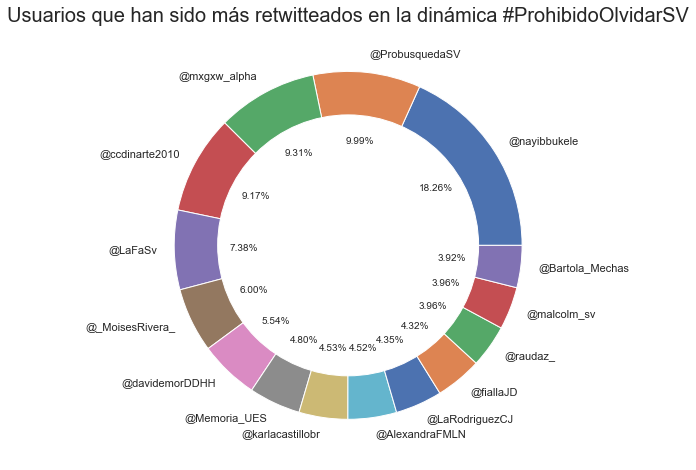

In [119]:
# Se define la información que se mostrará en el gráfico de "pastel"
# Debido a que son miles de usuarios, se toman los 15 con los valores más altos en cuanto a Retweets.
data = df[df['is_retweet']==True]['user'].value_counts(ascending=False)[:15]

my_circle=plt.Circle( (0,0), 0.75, color='white')

fig = plt.figure(figsize=(8,8))
plt.pie(data.values,
        labels=data.index,
        autopct='%1.2f%%')
plt.title("Usuarios que han sido más retwitteados en la dinámica #ProhibidoOlvidarSV", fontsize=20);
fig.gca().add_artist(my_circle)
plt.show()

### 6.2. Gráfico de Pastel sobre los Retweets por día en la semana

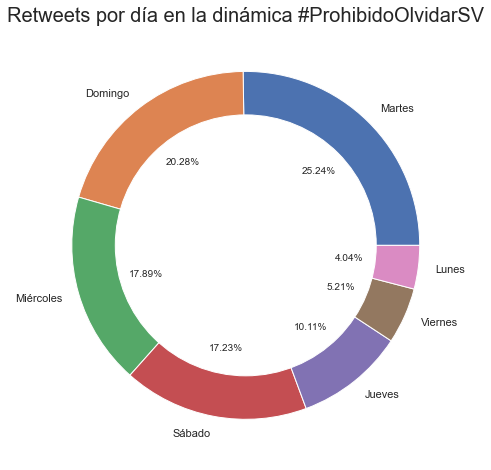

In [12]:
data = df[df['is_retweet']==True]['day'].value_counts(ascending=False)[:15]
my_circle=plt.Circle( (0,0), 0.75, color='white')

fig = plt.figure(figsize=(8,8))
plt.pie(data.values,
        labels=data.index,
        autopct='%1.2f%%')
plt.title("Retweets por día en la dinámica #ProhibidoOlvidarSV", fontsize=20);
fig.gca().add_artist(my_circle)
plt.show()

### 6.3. Los 10 usuarios que más Twittearon en la semana en la dinámica #ProhibidoOlvidarSV

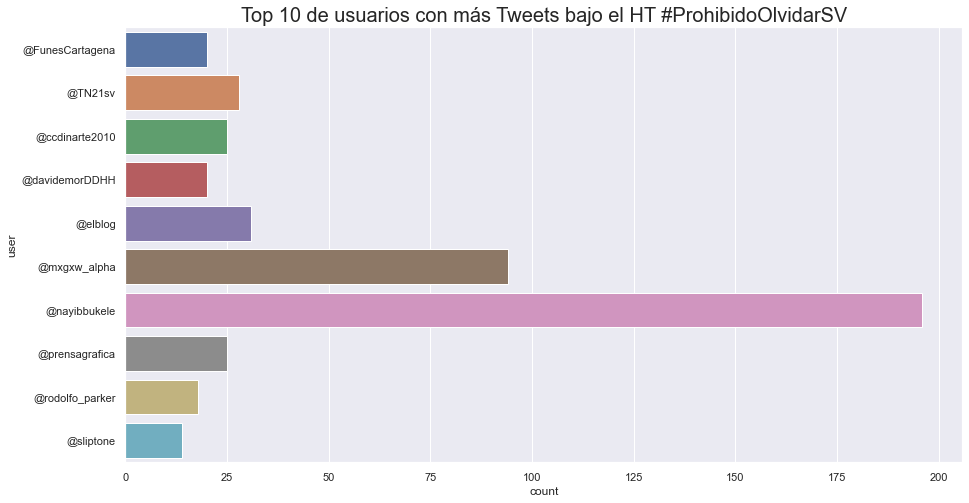

In [127]:
users = df_tw["user"].value_counts(ascending=False).index.to_list()[:10]
df_mod = df_tw[(df_tw['user'].isin(users))].sort_values(by='user')

fig = plt.figure(figsize=(15,8))
ax = sns.countplot(y="user", data=df_mod)
ax.set_title('Top 10 de usuarios con más Tweets bajo el HT #ProhibidoOlvidarSV', fontsize=20);

### 6.3. Los 10 usuarios que más Twittearon según el día de la semana

In [51]:
# Ordenamos el Dataset por fecha para que los registros aparezcan desde el día lunes al domingo.
df_tw = df_tw.sort_values(by='date').reset_index(drop=False)

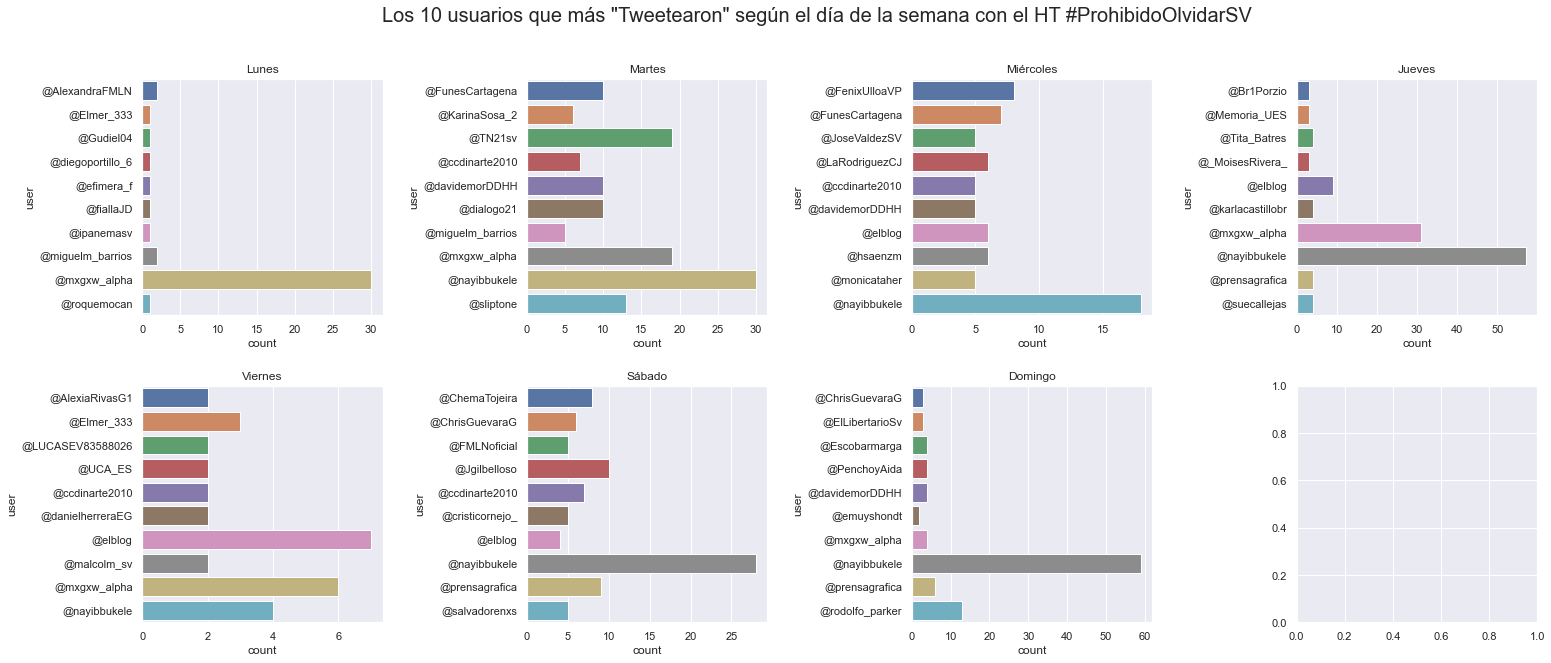

In [117]:
# Indices de los ejes del gráfico.
ax1 = 0
ax2 = 0

# Creamos una "subgráfica" para poder dividir una gráfica en varias secciones donde irán diferentes gráficas.
fig, axes = plt.subplots(2,4, figsize=(25,10))
fig.subplots_adjust(hspace=0.3, wspace=0.60)

# Iteramos según los días de la semana
for i in df_tw['day'].unique():
    
    # Obtenemos los 10 usuarios que tienen más tweets dependiendo del día de la semana
    users = df_tw[df_tw["day"]==i]["user"].value_counts(ascending=False).index.to_list()[:10]
    
    # En una variable guardamos aquellos registros que contengan alguno de los usuarios de la lista anterior y según el día contenido en la variable "i".
    df_mod = df_tw[(df_tw['user'].isin(users)) & (df_tw['day']==i)].sort_values(by='user')
    
    # Se crea un countplot, ya que permite indicar el eje en donde se colocará el gráfico. Se guarda en una variable.
    ct = sns.countplot(y="user", data=df_mod, ax=axes[ax1,ax2]);
    
    # Es posible asignarle un título al subgráfico en concreto que se acaba de crear. Se le asigna como título el día contenido en la variable "i".
    ct.set_title(i)
    
    # Para modificar el eje se utiliza este if que incrementa o "resetea" el valor de algún eje dependiendo del valor que tenga.
    if ax2 <= 3:
        ax2 = ax2 + 1
    if ax2 > 3:
        ax1 = 1
        ax2 = 0
    
    # Se agrega un título a todo el gráfico y se le asigna un tamaño de fuente.
    plt.suptitle('Los 10 usuarios que más "Tweetearon" según el día de la semana con el HT #ProhibidoOlvidarSV', fontsize=20);

### 6.4 Frecuencia de Tweets según hora y día de la semana con histogramas

In [13]:
# Se dividen los registros según el día, pero guardando únicamente el valor de la hora (para medir la cantidad de registros en una determinada hora en un día)

lunes = df[df['day']=='Lunes']['hour']
martes = df[df['day']=='Martes']['hour']
mierc = df[df['day']=='Miércoles']['hour']
jueves = df[df['day']=='Jueves']['hour']
viernes = df[df['day']=='Viernes']['hour']
sabado = df[df['day']=='Sábado']['hour']
domingo = df[df['day']=='Domingo']['hour']

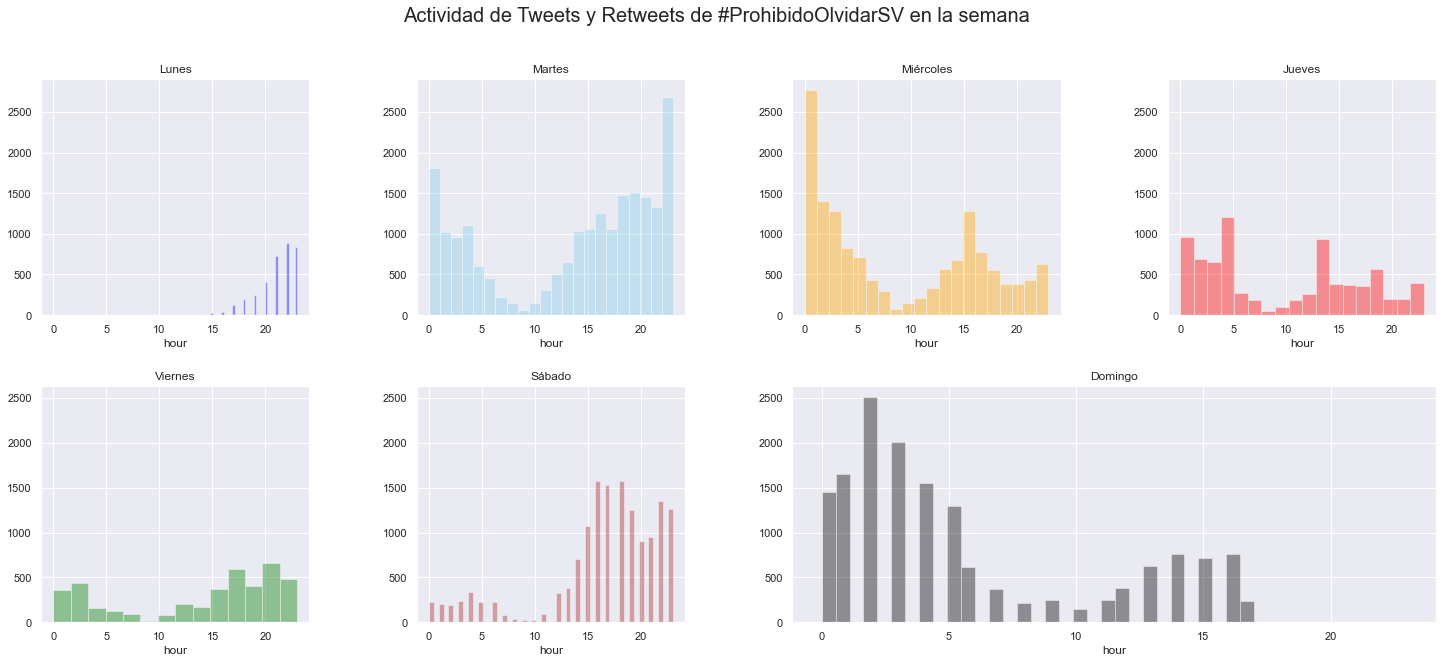

In [14]:
fig = plt.figure(figsize=(25, 10))
grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.3)

lun = fig.add_subplot(grid[0,0])
mar = fig.add_subplot(grid[0,1], sharey=lun, sharex=lun)
mier = fig.add_subplot(grid[0,2], sharey=lun, sharex=lun)
juev = fig.add_subplot(grid[0,3], sharey=lun, sharex=lun)
vier = fig.add_subplot(grid[1,0])
sab = fig.add_subplot(grid[1,1], sharey=vier, sharex=vier)
dom = fig.add_subplot(grid[1,2:], sharey=vier, sharex=vier)

sns.distplot(lunes,color='blue',kde=False, ax=lun, label='Lunes');
sns.distplot(martes,color='skyblue',kde=False, ax=mar);
sns.distplot(mierc,color='orange',kde=False, ax=mier);
sns.distplot(jueves,color='red',kde=False, ax=juev);
sns.distplot(viernes,color='green',kde=False, ax=vier);
sns.distplot(sabado,color='brown',kde=False, ax=sab);
sns.distplot(domingo,color='black',kde=False, ax=dom);

lun.set_title('Lunes')
mar.set_title('Martes')
mier.set_title('Miércoles')
juev.set_title('Jueves')
vier.set_title('Viernes')
sab.set_title('Sábado')
dom.set_title('Domingo')

plt.suptitle('Actividad de Tweets y Retweets de #ProhibidoOlvidarSV en la semana', fontsize=20);

### 6.5 Frecuencia de Tweets vs Retweets según hora y día de la semana con histogramas

Aquí, se divide el Dataset entre aquellos que son Retweets y los que no. Luego, procede a dividirse cada categoría por día y guardando únicamente el valor de la hora de forma s

In [15]:
lunes_rt = df[(df['day']=='Lunes')&(df['is_retweet']==True)]['hour']
martes_rt = df[(df['day']=='Martes')&(df['is_retweet']==True)]['hour']
mierc_rt = df[(df['day']=='Miércoles')&(df['is_retweet']==True)]['hour']
jueves_rt = df[(df['day']=='Jueves')&(df['is_retweet']==True)]['hour']
viernes_rt = df[(df['day']=='Viernes')&(df['is_retweet']==True)]['hour']
sabado_rt = df[(df['day']=='Sábado')&(df['is_retweet']==True)]['hour']
domingo_rt = df[(df['day']=='Domingo')&(df['is_retweet']==True)]['hour']

lunes_no_rt = df[(df['day']=='Lunes')&(df['is_retweet']==False)]['hour']
martes_no_rt = df[(df['day']=='Martes')&(df['is_retweet']==False)]['hour']
mierc_no_rt = df[(df['day']=='Miércoles')&(df['is_retweet']==False)]['hour']
jueves_no_rt = df[(df['day']=='Jueves')&(df['is_retweet']==False)]['hour']
viernes_no_rt = df[(df['day']=='Viernes')&(df['is_retweet']==False)]['hour']
sabado_no_rt = df[(df['day']=='Sábado')&(df['is_retweet']==False)]['hour']
domingo_no_rt = df[(df['day']=='Domingo')&(df['is_retweet']==False)]['hour']

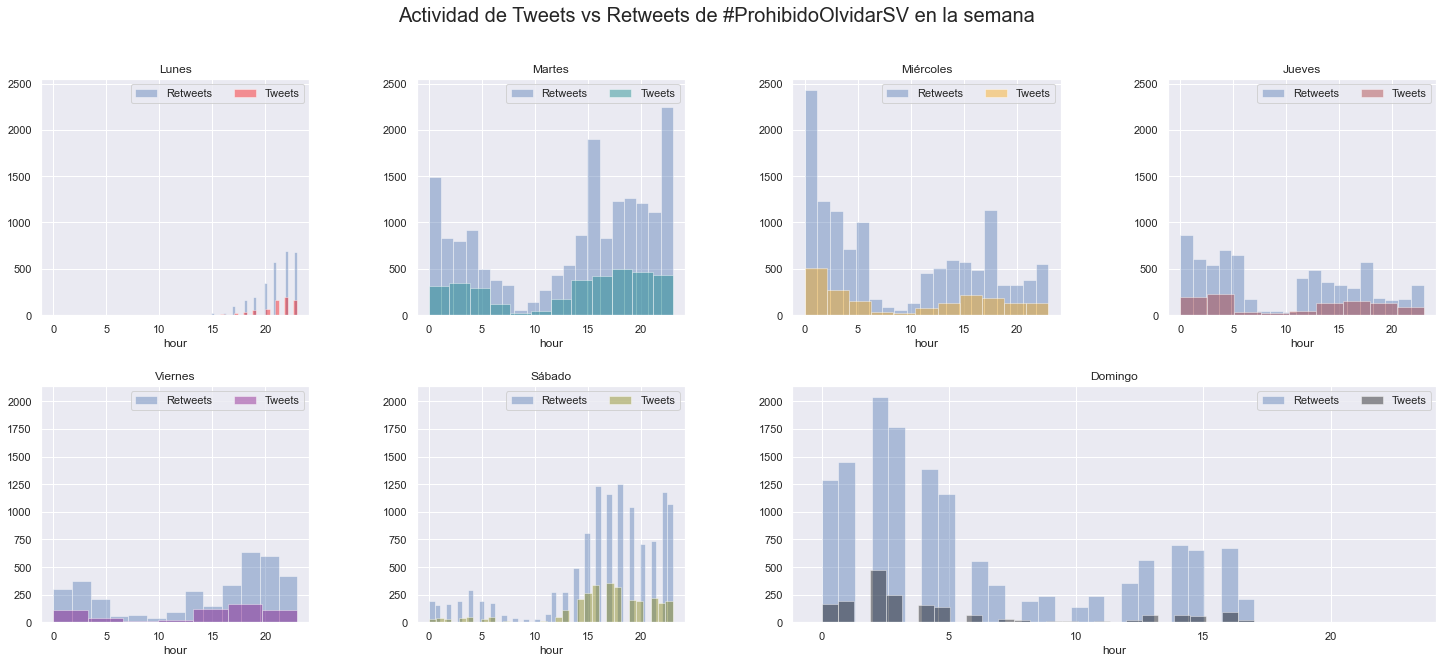

In [16]:
fig = plt.figure(figsize=(25, 10))
grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.3)

lun = fig.add_subplot(grid[0,0])
mar = fig.add_subplot(grid[0,1], sharey=lun, sharex=lun)
mier = fig.add_subplot(grid[0,2], sharey=lun, sharex=lun)
juev = fig.add_subplot(grid[0,3], sharey=lun, sharex=lun)
vier = fig.add_subplot(grid[1,0])
sab = fig.add_subplot(grid[1,1], sharey=vier, sharex=vier)
dom = fig.add_subplot(grid[1,2:], sharey=vier, sharex=vier)

sns.distplot(lunes_rt,kde=False, ax=lun, label='Retweets');
sns.distplot(lunes_no_rt,color='red',kde=False, ax=lun, label='Tweets');

sns.distplot(martes_rt,kde=False, ax=mar, label='Retweets');
sns.distplot(martes_no_rt,color='teal',kde=False, ax=mar, label='Tweets');

sns.distplot(mierc_rt,kde=False, ax=mier, label='Retweets');
sns.distplot(mierc_no_rt,color='orange',kde=False, ax=mier, label='Tweets');

sns.distplot(jueves_rt,kde=False, ax=juev, label='Retweets');
sns.distplot(jueves_no_rt,color='brown',kde=False, ax=juev, label='Tweets');

sns.distplot(viernes_rt,kde=False, ax=vier, label='Retweets');
sns.distplot(viernes_no_rt,color='purple',kde=False, ax=vier, label='Tweets');

sns.distplot(sabado_rt,kde=False, ax=sab, label='Retweets');
sns.distplot(sabado_no_rt,color='olive',kde=False, ax=sab, label='Tweets');

sns.distplot(domingo_rt,kde=False, ax=dom, label='Retweets');
sns.distplot(domingo_no_rt,color='black',kde=False, ax=dom, label='Tweets');

lun.set_title('Lunes')
mar.set_title('Martes')
mier.set_title('Miércoles')
juev.set_title('Jueves')
vier.set_title('Viernes')
sab.set_title('Sábado')
dom.set_title('Domingo')

lun.legend(ncol=2, loc="upper right", frameon=True)
mar.legend(ncol=2, loc="upper right", frameon=True)
mier.legend(ncol=2, loc="upper right", frameon=True)
juev.legend(ncol=2, loc="upper right", frameon=True)
vier.legend(ncol=2, loc="upper right", frameon=True)
sab.legend(ncol=2, loc="upper right", frameon=True)
dom.legend(ncol=2, loc="upper right", frameon=True)

plt.suptitle('Actividad de Tweets vs Retweets de #ProhibidoOlvidarSV en la semana', fontsize=20);
plt.show();